In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
from scipy.special import entr


!pip install PyWavelets
#statsmodel은 upgrade 버젼만 AutoReg 사용가능
!pip install statsmodels
!pip install statsmodels --upgrade

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

     |████████████████████████████████| 9.5 MB 3.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path_1st = '/content/drive/MyDrive/베어링 손상 예측/1st_test'
dataset_path_2nd = '/content/drive/MyDrive/베어링 손상 예측/2nd_test' 
dataset_path_3rd = '/content/drive/MyDrive/베어링 손상 예측/3rd_test' 

In [ ]:
# Test for the first file
dataset = pd.read_csv( dataset_path_3rd+'/2004.03.04.09.27.46', sep='\t')
dataset.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
dataset.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,0.103,0.083,-0.061,-0.012
1,0.095,-0.039,-0.007,0.039
2,0.000,0.110,0.022,-0.002
3,0.005,0.154,-0.127,-0.020
4,0.010,0.027,-0.007,-0.039


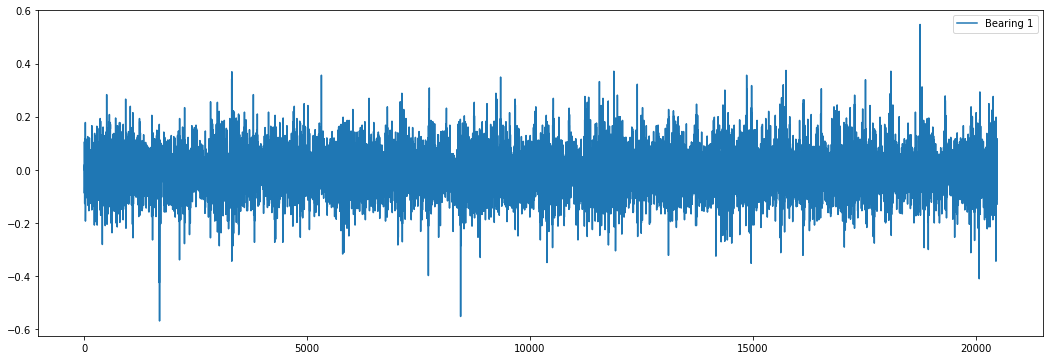

In [ ]:
# raw signal
dataset[['Bearing 1']].plot(figsize=(18,6));

In [ ]:
# old extract function
def merge_data(dataset_path, id_set=None):
    data = pd.DataFrame()
    for filename in os.listdir(dataset_path):
        dataset=pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        dataset_mean_abs = np.array(dataset.abs().mean())
        if id_set == 1:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,8))
        else:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
        dataset_mean_abs.index = [filename]
        data = data.append(dataset_mean_abs)
    
    if id_set == 1:
        data.columns = ['B1_a','B1_b','B2_a','B2_b','B3_a','B3_b','B4_a','B4_b'] #dataset1은 channel 8개
    else:
        data.columns = ['B1','B2','B3','B4']
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S') #년,월,일, 시,분,초
    data = data.sort_index()
    return data

# Extract Time Features
References:
http://mkalikatzarakis.eu/wp-content/uploads/2018/12/IMS_dset.html

In [ ]:
# 열 구성 어떤식으로 이루어지는 지 다시 확인

def calculate_rms(df): #제곱평균제곱근(root mean square; rms),  평균과 비슷한 수치
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    entropy = []
    for col in df:
        entropy.append(scipy.stats.entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(entropy)

def time_features(dataset_path, id_set=None):     #calculate 함수 실행
    #비대칭도 (Skewness), 첨도 (Kurtosis),평균 제곱근 편차(Root Mean Square Deviation; RMSD), peak to peak
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p']
    cols1 = ['B1_a','B1_b','B2_a','B2_b','B3_a','B3_b','B4_a','B4_b']
    cols2 = ['B1','B2','B3','B4']
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features] # 열 이름 설정
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t') #https://engineer-mole.tistory.com/188
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        
        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p], axis=1)
        data = data.append(merge)
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

In [ ]:
#%%time
set1 = time_features(dataset_path_1st, id_set=1)
set2 = time_features(dataset_path_2nd, id_set=2)
set3 = time_features(dataset_path_3rd, id_set=3)

In [ ]:
set2.isnull().sum().sum()

0

In [ ]:
set1.to_csv('set1_timefeatures.csv')
set2.to_csv('set2_timefeatures.csv')
set3.to_csv('set3_timefeatures.csv')

In [ ]:
set2 = pd.read_csv("./set2_timefeatures.csv")
set2.describe().T

,count,mean,std,min,25%,50%,75%,max
B1_mean,984.0,0.080905,0.040171,0.001168,0.060765,0.062007,0.083223,0.453335
B1_std,984.0,0.106090,0.058234,0.000987,0.077112,0.078748,0.108790,0.725031
B1_skew,984.0,-0.033128,0.089037,-0.766212,-0.047476,-0.009827,0.013673,0.579749
B1_kurtosis,984.0,0.827643,0.966001,-1.609923,0.393975,0.485346,0.879248,14.113736
B1_entropy,984.0,4.985982,0.260623,0.592386,4.860787,4.880541,5.135371,5.676568
B1_rms,984.0,0.106111,0.058225,0.001533,0.077136,0.078779,0.108819,0.725019
B1_max,984.0,0.555001,0.388084,0.005000,0.393000,0.442000,0.576000,5.000000
B1_p2p,984.0,1.054736,0.740102,0.005000,0.752000,0.830000,1.101750,9.998000
B2_mean,984.0,0.078532,0.011779,0.000767,0.074233,0.075203,0.077456,0.161016
B2_std,984.0,0.098731,0.014757,0.001021,0.093402,0.094656,0.097344,0.218303
